In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [3]:
# Load dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Quick look
print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Info & Missing Values
df.info()
df.isnull().sum()

# Target distribution
df['Churn'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,proportion
Churn,
No,0.73463
Yes,0.26537


In [5]:
# Convert TotalCharges to numeric (it sometimes has blanks)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Encode target
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


/tmp/ipython-input-3525333531.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


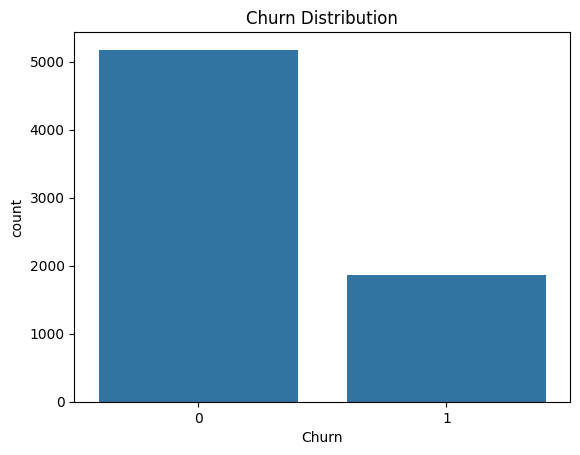

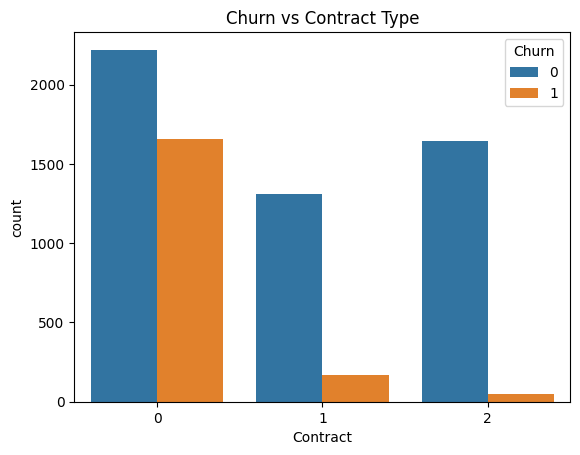

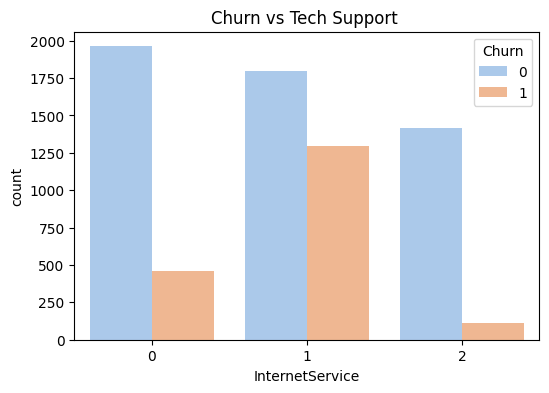

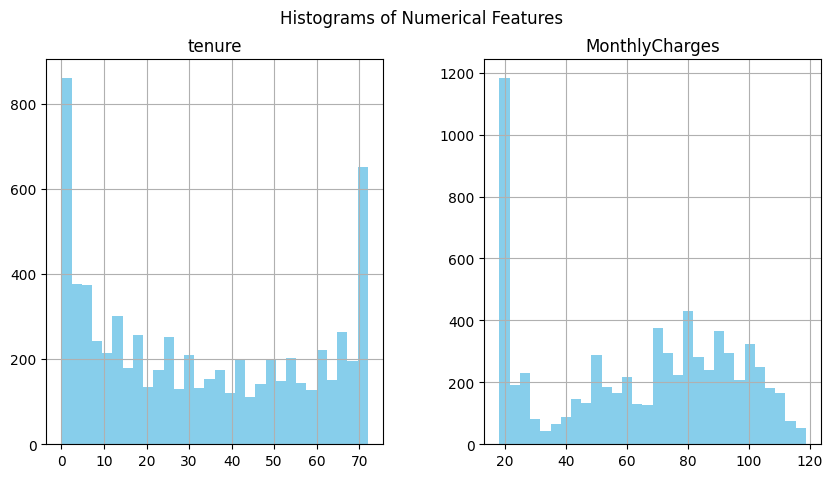

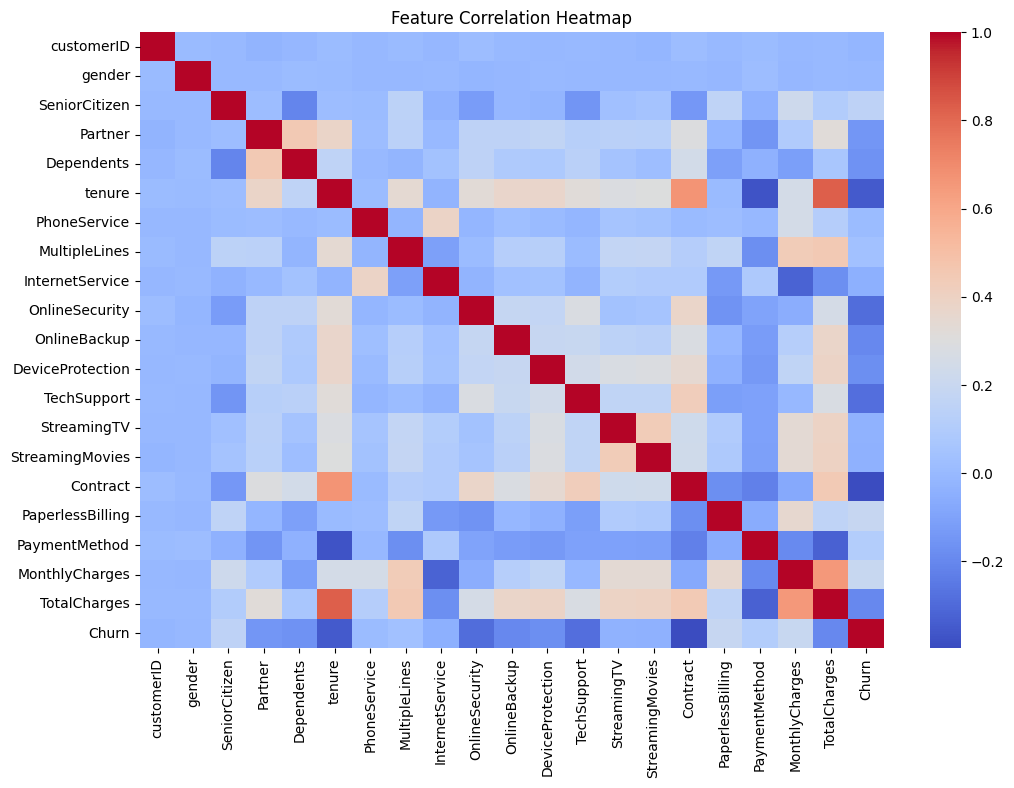

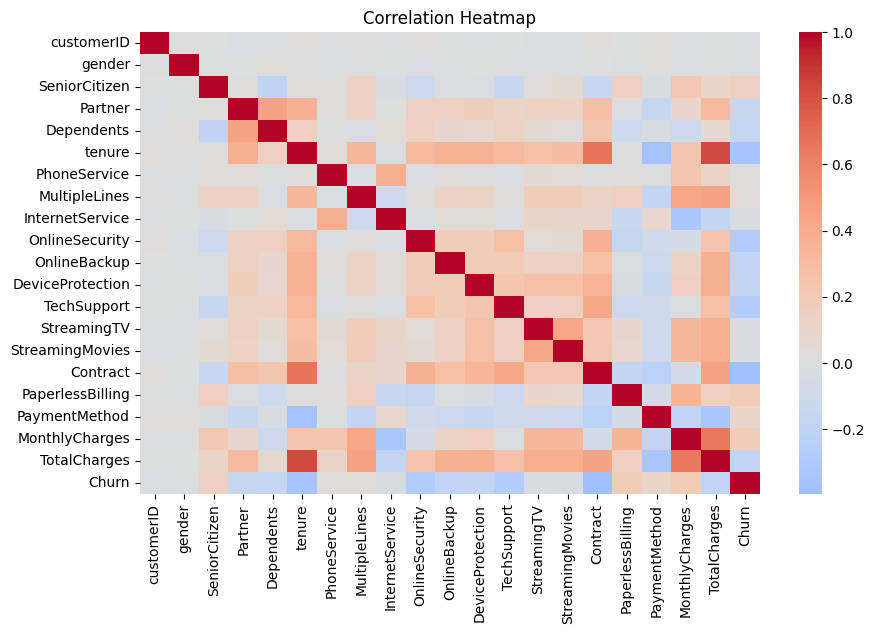

In [11]:
# Churn distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

# Churn by Contract Type
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn vs Contract Type")
plt.show()

# --- 5. Churn vs InternetService ---
plt.figure(figsize=(6,4))
sns.countplot(x='InternetService', hue='Churn', data=df, palette='pastel')
plt.title("Churn vs Tech Support ")
plt.show()

# . Histograms ---
df[['tenure','MonthlyCharges']].hist(bins=30, figsize=(10,5), color='skyblue')
plt.suptitle("Histograms of Numerical Features")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# --- 7. Correlation Heatmap ---
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()




In [7]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numeric columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [8]:
# --------------------------
# Step 7: Model Training & Evaluation
# --------------------------

from sklearn.tree import DecisionTreeClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    results.append([name,
                    accuracy_score(y_test, y_pred),
                    auc])

    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{name} ROC-AUC: {auc:.4f}")

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC-AUC"])
results_df


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1552
           1       0.65      0.56      0.60       561

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.80      0.80      0.80      2113

Logistic Regression ROC-AUC: 0.8425

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1552
           1       0.50      0.50      0.50       561

    accuracy                           0.73      2113
   macro avg       0.66      0.66      0.66      2113
weighted avg       0.73      0.73      0.73      2113

Decision Tree ROC-AUC: 0.6569

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1552
           1       0.64      0.48      0.55     

,Model,Accuracy,ROC-AUC
0,Logistic Regression,0.802650,0.842534
1,Decision Tree,0.732608,0.656921
2,Random Forest,0.790345,0.824089
3,Gradient Boosting,0.798391,0.839456


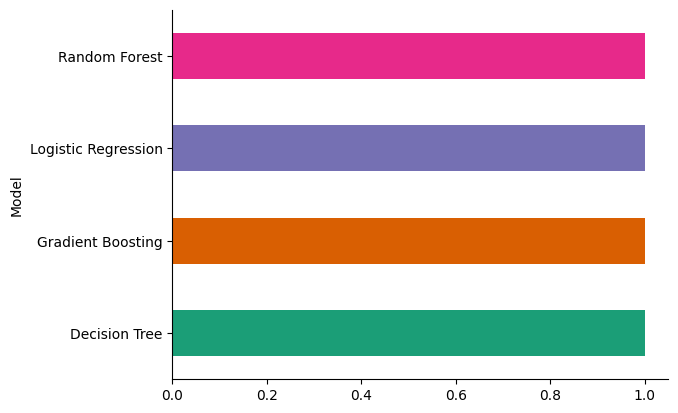

In [10]:
# @title Model

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best AUC:", grid.best_score_)


In [ ]:
importances = rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Top 15 Feature Importances")
plt.show()


In [ ]:
import joblib
joblib.dump(rf, "churn_model.pkl")
